## Street Modell
In this Notebook we create a street model based on fastai to predict the street in a given image. We therefore use masks that were manually created in labelMe. We marked all streats as a polygon in labelMe.
With this model we want to make sure that we later have the possibility to only look at cars on a street and also reduce the noise by removing images that do not contain a street.
We played around with different hyperparameters but decided to stay with the ones initially used in the fastai Street Modell, cause this one has the best performance mixed with a good training time.

In [1]:
from fastai.vision.all import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Fast_AI Street Modell

In [2]:
path = Path("/kaggle/input/car-street-data/train_test_split_car")
train_path = path/"train"
test_path = path/"test"

In [3]:
# define a function to get the images
def get_images(name):
    files = get_image_files("/kaggle/input/car-street-data/train_test_split_car")
    jpg_files = [f for f in files if f.suffix == '.jpg']
    return jpg_files

In [4]:
# define a function to get the numpy mask for the given path
def get_mask(path):
    #remove the file name and extension from the path
    path = path.parent 
    # add the name mask.npy to the path
    path = path.joinpath("label_street_mask.npy")
    return np.load(path)

In [5]:
#create a Datablock with the masks and images
satellite_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["background","street"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3)
)

In [6]:
#optimizer for better performance
opt_func = Adam

In [8]:
#create the dataloader based on the Datablock
dataloader = satellite_block.dataloaders("./", bs=10)

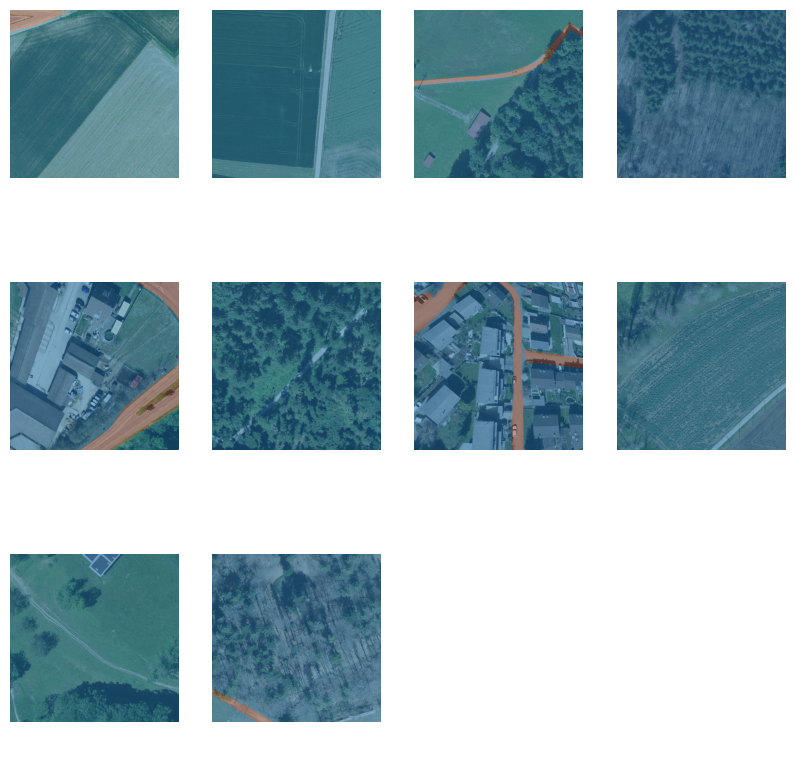

In [9]:
dataloader.show_batch(max_n=10, figsize=(10,10))

### define metrics

In [10]:
# define functions to calculate desired metrics
def convert_preds_and_target(pred, target):
    # convert predictions to numpy array with max probability index
    pred = pred.argmax(dim=1).cpu().numpy()
    # convert target to numpy array
    target = target.cpu().numpy()

    return pred, target

def calculate_intersect_union(pred, target):
    # calculate intersection and union
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)

    return intersection, union

def calculate_iou(intersection, union):
    # calculate intersection over union
    return np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 1

def calculate_accuracy(pred, target):
    # calculate accuracy
    return np.sum(pred == target) / np.prod(target.shape)

def calculate_dice(intersection, union):
    # calculate dice coefficient
    return 2 * np.sum(intersection) / (np.sum(union) + np.sum(intersection)) if np.sum(union) != 0 else 1

def iou(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate intersection and union
    intersection, union = calculate_intersect_union(pred, target)
    # calculate intersection over union
    return calculate_iou(intersection, union)

def dice(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate intersection and union
    intersection, union = calculate_intersect_union(pred, target)
    # calculate dice coefficient
    return calculate_dice(intersection, union)

def accuracy(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate accuracy
    return calculate_accuracy(pred, target)

### create a learner and train it in a frozen state


In [14]:

learner = unet_learner(dataloader,resnet34,metrics=[dice, iou, accuracy],opt_func=opt_func)

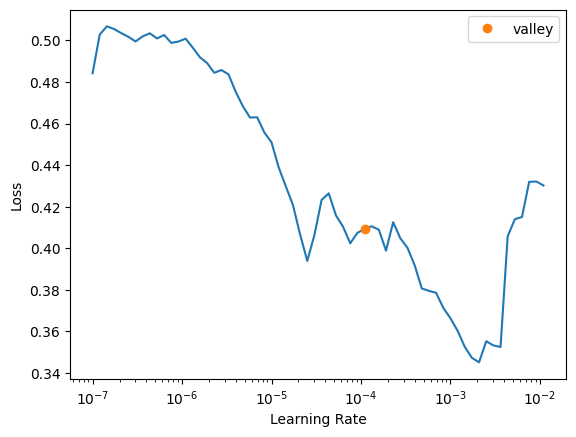

In [15]:
lr = learner.lr_find()

In [16]:
learner.fit_one_cycle(20, lr_max=lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,dice,iou,accuracy,time
0,0.170928,0.118235,0.593228,0.433875,0.954337,02:36
1,0.131993,0.100234,0.626977,0.471706,0.963367,02:36
2,0.109661,0.087412,0.661680,0.509725,0.967318,02:35
3,0.097596,0.076703,0.714513,0.570039,0.970479,02:35
4,0.086485,0.075206,0.733245,0.593054,0.970369,02:35
5,0.073693,0.070290,0.762391,0.630209,0.972673,02:36
6,0.073139,0.084234,0.692072,0.542840,0.969601,02:35
7,0.072636,0.064901,0.782189,0.654749,0.974849,02:36
8,0.067679,0.065139,0.780093,0.652257,0.975015,02:36
9,0.061583,0.063190,0.787230,0.662045,0.975716,02:35


Better model found at epoch 0 with dice value: 0.5932275470117756.
Better model found at epoch 1 with dice value: 0.6269774483489341.
Better model found at epoch 2 with dice value: 0.6616800628786038.
Better model found at epoch 3 with dice value: 0.7145132339616121.
Better model found at epoch 4 with dice value: 0.7332453158663946.
Better model found at epoch 5 with dice value: 0.7623912297736424.
Better model found at epoch 7 with dice value: 0.782188786047541.
Better model found at epoch 13 with dice value: 0.8024404045004332.


### create an unfrozen learner and train it

In [17]:
learner = learner.load('best_frozen_model')
learner.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


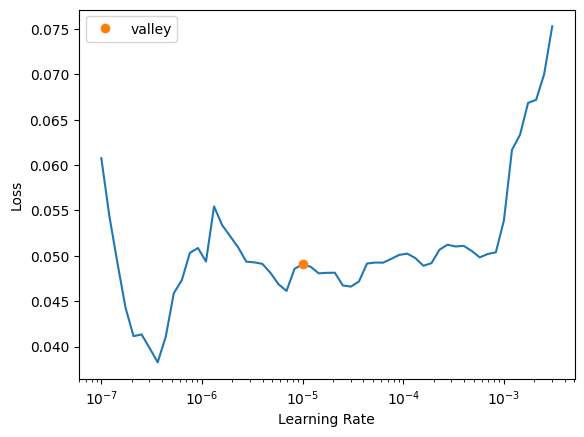

In [18]:
lr = learner.lr_find()

In [19]:
learner.fit_one_cycle(
    20, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,dice,iou,accuracy,time
0,0.052806,0.060036,0.800766,0.679265,0.977658,02:41
1,0.054421,0.059912,0.802108,0.679921,0.977145,02:41
2,0.055544,0.069661,0.789171,0.665689,0.973886,02:41
3,0.054113,0.063035,0.799243,0.676072,0.975715,02:41
4,0.053287,0.065162,0.793138,0.670952,0.974946,02:40
5,0.047401,0.060917,0.806888,0.686509,0.977024,02:39
6,0.050117,0.064882,0.786297,0.658082,0.977206,02:39
7,0.046983,0.059137,0.802025,0.680437,0.976989,02:39
8,0.045646,0.061710,0.812205,0.694045,0.978334,02:39
9,0.042011,0.060957,0.802454,0.681378,0.978137,02:39


Better model found at epoch 0 with dice value: 0.8007663099587446.
Better model found at epoch 1 with dice value: 0.8021079079142628.
Better model found at epoch 5 with dice value: 0.8068879309683883.
Better model found at epoch 8 with dice value: 0.812204730995643.
Better model found at epoch 10 with dice value: 0.8137238637594657.
Better model found at epoch 11 with dice value: 0.8206532050372128.
No improvement since epoch 8: early stopping


### check the performance with the dice score

In [20]:
learner = learner.load("best_model")

In [21]:
print("in-sample performance: {}".format(np.array(learner.validate(ds_idx=0)[1]))) # Dice Score

in-sample performance: 0.8778906292338261


In [22]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.8206532050372128


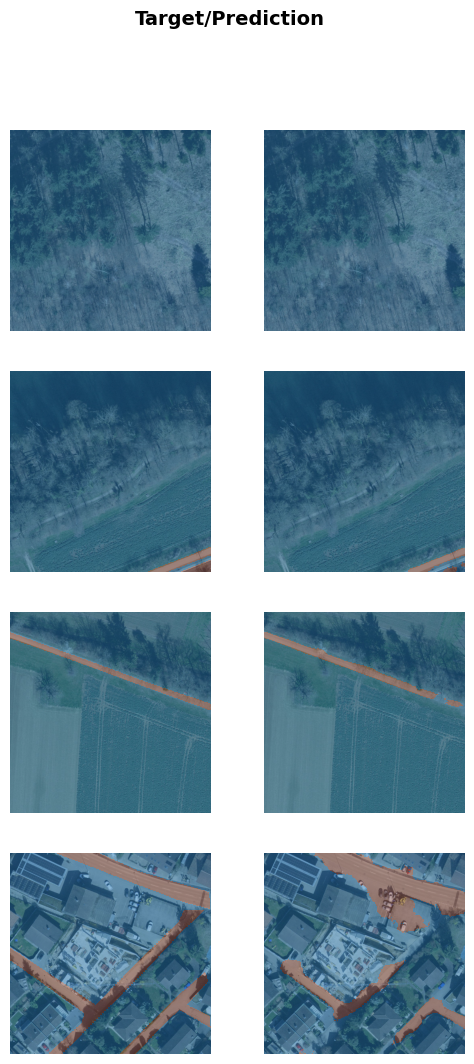

In [25]:
learner.show_results(max_n=4)

## Trying different Hyperparameters to see if the performance gets better

In [10]:
# creating the datablock with different hyperparameters
satellite_block_tuned = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=["background", "street"])),
    get_items=get_images,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Änderung des Splitters zu RandomSplitter
    get_y=mask_function,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

In [11]:
dataloader_tuned = satellite_block_tuned.dataloaders(path, bs=10)

In [14]:
learner_tuned = unet_learner(dataloader_tuned,resnet34,metrics=Dice,opt_func=opt_func)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.1MB/s]


### create a learner in a frozen state and learn it


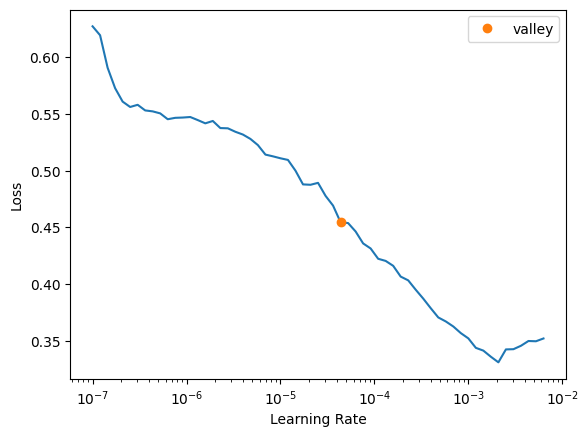

In [15]:
lr_tuned = learner_tuned.lr_find() 

In [16]:
learner_tuned.fit_one_cycle(20, lr_max=lr_tuned.valley,
                      cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_tuned_model')])

epoch,train_loss,valid_loss,dice,time
0,0.252276,0.175167,0.025080,00:59
1,0.148751,0.105229,0.625182,00:55
2,0.126750,0.086794,0.699111,00:55
3,0.102586,0.153693,0.618337,00:56
4,0.093331,0.071688,0.750128,00:55
5,0.106954,0.093308,0.757717,00:56
6,0.084075,0.064790,0.756661,00:55
7,0.083508,0.077177,0.766438,00:56
8,0.074868,0.062817,0.800135,00:55
9,0.071975,0.060128,0.798738,00:55


Better model found at epoch 0 with dice value: 0.0250803616138012.
Better model found at epoch 1 with dice value: 0.6251819324963573.
Better model found at epoch 2 with dice value: 0.6991109715919308.
Better model found at epoch 4 with dice value: 0.7501279220443448.
Better model found at epoch 7 with dice value: 0.7664377068724291.
Better model found at epoch 8 with dice value: 0.800135374330172.
Better model found at epoch 15 with dice value: 0.8111604467761824.


In [20]:
# Modell laden und unfreezen
learner_tuned = learner_tuned.load('best_frozen_tuned_model')
learner_tuned.unfreeze()

### unfreeze the learner and train it again

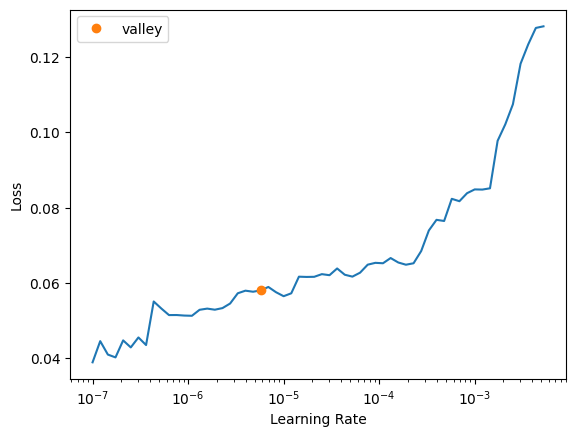

In [21]:
lr_tuned = learner_tuned.lr_find() 

In [26]:
learner_tuned.fit_one_cycle(
    20, lr_max=slice(lr_tuned.valley / 10, lr_tuned.valley * 10),
    cbs=[
        EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
        SaveModelCallback(monitor='dice', comp=np.greater, fname='best_tuned_model')
    ]
)

epoch,train_loss,valid_loss,dice,time
0,0.043074,0.055101,0.828432,01:00
1,0.040591,0.057061,0.827925,01:00
2,0.042758,0.054123,0.828358,01:01
3,0.049436,0.052396,0.819780,01:02
4,0.046120,0.057546,0.819710,01:02
5,0.045777,0.058253,0.820013,01:01
6,0.044142,0.051218,0.831720,01:00
7,0.045576,0.061191,0.810233,01:00
8,0.040503,0.059024,0.824446,01:00
9,0.041960,0.051566,0.829179,01:01


Better model found at epoch 0 with dice value: 0.828431570119157.
Better model found at epoch 6 with dice value: 0.8317195012808445.
No improvement since epoch 0: early stopping


### check the performance

In [27]:
learner_tuned = learner_tuned.load('best_tuned_model')

In [28]:
print("out-of-sample performance: {}".format(np.array(learner_tuned.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.8317195012808445


In [29]:
print("In-Sample Performance: {}".format(np.array(learner_tuned.validate(ds_idx=0)[1])))  # Dice Score

In-Sample Performance: 0.884161366593624
